In [1]:
import torch
torch.cuda.set_device(0)
from rsnautils import *
from fastai2.callback.data import *
from fastai2.vision.all import *

nw = 8
pre = 'rn34_wgtd'

### Position / windowing

In [2]:
def add_pos(df):
    df = df.sort_values(['SeriesInstanceUID','ImagePositionPatient2'])
    sopid = pd.Series(df.index, index=df.index)
    series_id = df.SeriesInstanceUID
    
    next_series = series_id.shift(-1)
    right = sopid.shift(-1).fillna('')
    right_dist = df.ImagePositionPatient2.diff().shift(-1)
    right.loc[series_id != next_series] = ''
    right_dist.loc[series_id != next_series] = 0.0
    
    prev_series = series_id.shift(1)
    left = sopid.shift(1).fillna('')
    left_dist = right_dist.shift(1).fillna(0.0)
    left.loc[series_id != prev_series] = ''
    left_dist.loc[series_id != prev_series] = 0.0
    
    return df.assign(Right=right,Left=left,LeftDist=left_dist,RightDist=right_dist).reset_index()

In [3]:
pos_flds = 'Right Left LeftDist RightDist'.split()

In [16]:
df_comb = pd.read_feather(path_meta/'df_comb2.fth').set_index('SOPInstanceUID')

In [20]:
df_res.columns

Index(['SOPInstanceUID', 'Modality', 'PatientID', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'ImagePositionPatient',
       'ImageOrientationPatient', 'SamplesPerPixel',
       'PhotometricInterpretation', 'Rows', 'Columns', 'PixelSpacing',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'WindowCenter', 'WindowWidth', 'RescaleIntercept', 'RescaleSlope',
       'fname', 'MultiImagePositionPatient', 'ImagePositionPatient1',
       'ImagePositionPatient2', 'MultiImageOrientationPatient',
       'ImageOrientationPatient1', 'ImageOrientationPatient2',
       'ImageOrientationPatient3', 'ImageOrientationPatient4',
       'ImageOrientationPatient5', 'MultiPixelSpacing', 'PixelSpacing1',
       'img_min', 'img_max', 'img_mean', 'img_std', 'img_pct_window',
       'MultiWindowCenter', 'WindowCenter1', 'MultiWindowWidth',
       'WindowWidth1', 'any', 'epidural', 'intraparenchymal',
       'intraventricular', 'subarachnoid', 'subdural', 'Right', 'Le

In [ ]:
# df_res = add_pos(df_comb)

In [23]:
df_res.to_feather(path_meta/'df_comb2.fth')
len(df_res)

752802

In [5]:
# df_res = add_pos(df_tst)
# df_res.to_feather(path_meta/'df_tst.fth')
# len(df_res)

In [6]:
(df_comb.Right=='').mean(),(df_comb.Left=='').mean(),df_comb.query("Right!=''").RightDist.mean()

(0.02896521652722923, 0.02896521652722923, 4.8891488908206915)

In [7]:
(df_tst .Right=='').mean(),(df_tst .Left=='').mean(),df_tst .query("Right!=''").RightDist.mean()

(0.02818766312305048, 0.02818766312305048, 4.653973893877878)

In [8]:
# df_comb.sort_values(['SeriesInstanceUID','ImagePositionPatient2'])[
#     ['SeriesInstanceUID','ImagePositionPatient2','PositionOrd']].tail(200)

In [9]:
df_comb['PositionOrd'] = df_comb.groupby('SeriesInstanceUID')['ImagePositionPatient2'].rank().astype(int)

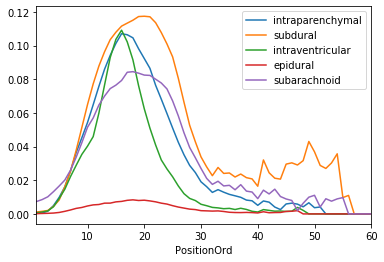

In [10]:
df_comb.groupby('PositionOrd')[['intraparenchymal', 'subdural', 'intraventricular',
                                'epidural','subarachnoid']].mean().plot();

In [11]:
def dcm_fn(p,sop): return (p/sop).with_suffix('.dcm')

def surround_dcm(p, df, idx):
    rec = df.loc[idx]
    left,right = rec.Left,rec.Right
    dcm = dcm_tfm(dcm_fn(p,idx))
    if left != '': dcm_l = dcm_tfm(dcm_fn(p,left))
    else: dcm_l = torch.zeros_like(dcm)
    if right != '': dcm_r = dcm_tfm(dcm_fn(p,right))
    else: dcm_r = torch.zeros_like(dcm)
    return TensorCTScan(torch.stack([dcm,dcm_l,dcm_r]))

In [12]:
def surround2chans(dcms):
    dcm,dcm_l,dcm_r = dcms 
    t_l,t_r = dcm_l.hist_scaled(bins),dcm_r.hist_scaled(bins)
    return TensorCTScan(torch.cat([*dcm.to_3chan(*brain_wins, bins=bins), t_l, t_r]))

In [17]:
def surround2chans(dcms):
    dcm,dcm_l,dcm_r = dcms 
    t_l,t_r = dcm_l.windowed(*dicom_windows.subdural),dcm_r.windowed(*dicom_windows.subdural)
    return TensorCTScan(torch.cat([*dcm.to_nchan(**soft_args), t_l, t_r]))

In [18]:
# dest = path/'tst5_jpg'
dest = path/'train5b_jpg'
dest.mkdir(exist_ok=True)

In [19]:
def surround2chans_tfm(p, df, idx):
    o = surround_dcm(p, df, idx)
    res = (surround2chans(o)*(2**8-1)).byte()
    im = Image.fromarray(res.numpy())
    im.save(dest/f'{idx}.jpg')

In [20]:
idx = df_comb.iloc[13].name
dcms = surround_dcm(path_trn, df_comb, idx)
# show_images(dcms)

In [41]:
# dcms = surround2chans_tfm(path_trn, df_comb, idx)
# show_image(array(dcms).T, figsize=(12,3));

In [21]:
class SurroundProc:
    def __init__(self, p, df): self.p,self.df = p,df
    def __call__(self, b): return (surround2chans_tfm(self.p, self.df, b_) for b_ in b)

In [22]:
# s = SurroundProc(p=path_tstd, df=df_sub)
# for o in s(df_sub.index.values[:10]): pass

In [20]:
# %%time
# df_sub = df_tst[["Left","Right"]]
# path_tstd = Path('/home/jhoward/data/rsna/stage_1_test_images')

# for i,o in enumerate(parallel_gen(SurroundProc, df_sub.index.values, n_workers=24, p=path_tstd, df=df_sub)): pass

In [21]:
# %%time
# df_sub = df_comb[["Left","Right"]]

# for i,o in enumerate(parallel_gen(SurroundProc, df_sub.index.values, n_workers=24, p=path_trn, df=df_sub)): pass

In [44]:
%%time
df_sub = df_comb[["Left","Right"]]

for i,o in enumerate(parallel_gen(SurroundProc, df_sub.index.values, n_workers=24, p=path_trn, df=df_sub)): pass

CPU times: user 2min 1s, sys: 22.4 s, total: 2min 24s
Wall time: 21min 54s


In [43]:
dest.ls(100)

(#1) [/home/jhoward/data/rsna/train5b_jpg/ID_1a5bac972.jpg]

In [24]:
splits = split_data(df_comb,0)
f_in  = partial(surround_dcm, path_trn,df_comb)
dsets = Datasets(df_comb.index.values, f_in, splits=splits)

In [25]:
class WindTfm(ItemTransform):
    order = 1
    def encodes(self, x):
        dcm,dcm_l,dcm_r = x[0].transpose(0,1)
        t_l,t_r = dcm_l.windowed(*dicom_windows.subdural),dcm_r.windowed(*dicom_windows.subdural)
        y = torch.cat([dcm.to_nchan(bone_wins, bins=0), t_l.unsqueeze(1), t_r.unsqueeze(1)], dim=1)
        return x[0]/1000,y*2-1

In [26]:
dls = dsets.dataloaders(bs=32, num_workers=4, after_batch=L(WindTfm, Cuda()))
x,y = dls.train.one_batch()

In [27]:
idx=0
#show_images(x[idx])

In [28]:
#show_images(y[idx])

In [29]:
x[idx].mean(),x[idx].std(),y[idx].mean(),y[idx].std()

(tensor(-1.0919, device='cuda:0'),
 tensor(1.1549, device='cuda:0'),
 tensor(-0.7609, device='cuda:0'),
 tensor(0.5676, device='cuda:0'))

In [31]:
m = nn.Sequential(
    ConvLayer(3, 16, 1, act_cls=nn.LeakyReLU, bn_1st=False),
    ConvLayer(16, 5, 1, act_cls=nn.Tanh,  bn_1st=False),
).cuda()

In [32]:
lf = nn.L1Loss()
optf = partial(Adam, wd=1e-3)
learn = Learner(dls, m, loss_func=lf, opt_func=optf)
m

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (1): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvLayer(
    (0): Conv2d(16, 5, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Tanh()
    (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [37]:
learn.fit(1, 0.01)

In [36]:
p = m(x)
pi = p[idx]
yi = y[idx]
lf(p,y)

tensor(0.0517, device='cuda:0', grad_fn=<L1LossBackward>)

In [45]:
p = m(x)
pi = p[idx]
yi = y[idx]
lf(p,y)

tensor(0.0311, device='cuda:0', grad_fn=<L1LossBackward>)

In [139]:
save_model('pre_stem.pth', m, None)

In [141]:
load_model('pre_stem.pth', m, None)

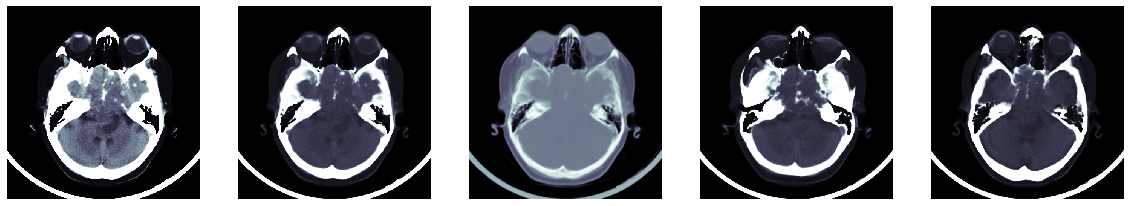

In [46]:
show_images(pi)

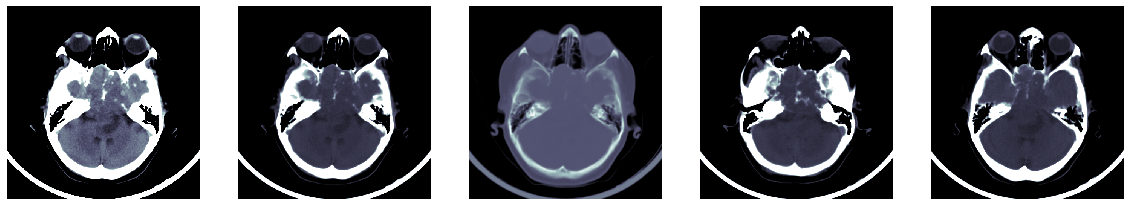

In [47]:
show_images(yi)

In [41]:
y.mean((0,2,3))

tensor([-0.6943, -0.7646, -0.7810, -0.7564, -0.7663], device='cuda:0')

In [42]:
p.mean((0,2,3))

tensor([-0.6683, -0.7476, -0.7619, -0.7425, -0.7477], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [43]:
y.std((0,2,3))

tensor([0.6078, 0.5247, 0.3482, 0.5249, 0.5134], device='cuda:0')

In [44]:
p.std((0,2,3))

tensor([0.5986, 0.5280, 0.3562, 0.5345, 0.5081], device='cuda:0',
       grad_fn=<StdBackward1>)

In [45]:
y[0].max(),y[0].min()

(tensor(1., device='cuda:0'), tensor(-1., device='cuda:0'))

In [46]:
p[0].max(),p[0].min()

(tensor(1.0186, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-1.0830, device='cuda:0', grad_fn=<MinBackward1>))